In [1]:
import pandas as pd
import numpy as np
import matplotlib.style as style
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import re
from datetime import datetime
from collections import defaultdict
import itertools
from random import choices
from collections import Counter
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.metrics import mean_squared_error
style.use('fivethirtyeight')
pd.options.display.max_columns = 999
pd.options.display.float_format = '{:,.3f}'.format
%matplotlib inline  

In [2]:
#get price bins
def PriceRange(priceArray):
    #Create price bins for both datasets
    bins = [0, 300000, 650000]
    priceRange_dict = {1:'Low',2:'Mid',3:'High'}
    return list(map(lambda x:priceRange_dict[x],np.searchsorted(bins,priceArray)))

StarKLregion_dict = {'North':['Kepong','Batu','Wangsa Maju','Setiawangsa'],
                'Central':['Segambut','Bukit Bintang','Titiwangsa','Lembah Pantai'],
                'South':['Cheras','Bandar Tun Razak','Seputeh']}
#map into region from district for star
StarSelregion_dict = {'Petaling Jaya':'Petaling',
                     'Hulu Selangor':'Hulu Selangor',
                     'Klang':'Klang',
                     'Batu':'Gombak',
                     'Ulu Langat':'Hulu Langat',
                     'Sepang':'Sepang',
                     'Kuala Langat':'Kuala Langat',
                     'Kuala Selangor':'Kuala Selangor'}
#get region
def getRegion(state_Array,district_Array):
    region_Array = []
    for no,state in enumerate(state_Array):
        if state == 'Kuala Lumpur':
            region_Array.append(''.join([i for i,j in StarKLregion_dict.items() if district_Array[no] in j]))
        elif state == 'Selangor':
            if district_Array[no] in StarSelregion_dict.keys():
                region_Array.append(StarSelregion_dict[district_Array[no]])
            else:
                region_Array.append('')
        else:
            region_Array.append('')
    return region_Array

In [5]:
#Star

df_star = pd.read_csv('../data/processed/Propwall_Report_ForSale-28-3-18.csv')
# Load Property to District mapping
df_district = pd.read_excel('../data/external/kl_sel_districted.xlsx')
# Join the two set using Location_property as key
df_star = df_star.join(df_district, on='Location_property')
#save unique location_property to naz for getting public transport info for sales
pd.Series(df_star['Location_property'].unique(),name = 'Location_property')\
.to_excel('../data/excel/UniqueLocationProperty_StarSales.xlsx')

#add column of quarter and year-quarter
df_star['quarter'] = ((df_star['month']-1)//3+1)

df_star['year-quarter'] = df_star['year'].astype(str) + '-' + df_star['quarter'].astype(str)
df_star['State'] = df_star['State'].map(lambda x:'Selangor' if x == 'Petaling Jaya' else x)
df_star['State_Category'] = df_star['State'].map(lambda x:'Others' if x not in ['Kuala Lumpur','Selangor']
                                                else x)
#breakdown into region from district for star
df_star['region_type'] = getRegion(df_star['State'].values,df_star['district_master'].values)

#external data (distance to public transport)
df_transport = pd.read_excel('../data/excel/RentalPropertiesWithDistanceToPublicRails.xlsx')
#merge external data with rental data
df_star = df_star.merge(df_transport, on = 'Location_property', how = 'left')

#fill carpark, most of carpark is 0
df_star['carpark'] = df_star['carpark'].map(lambda x:2 if x == 0  else x)

df_star['num_bath'] = df_star\
                            .apply(lambda row: row['bath'] if row['bath'] != 0 \
                                   else math.ceil(row['num_bedroom']/2), axis=1)

#choose KL and Selangor
df_merged_KlSel = df_star[df_star['State'].isin(['Kuala Lumpur','Selangor'])].copy()
def VicinityToPT(df,transportType,threshold = 0.8):
    if [i for i in df_merged_KlSel.columns if 'dist-to-{}'.format(transportType) in i]:
        return np.any([df[i]<threshold for i in df_merged_KlSel.columns if 'dist-to-{}'.format(transportType) in i])
    #else:
        #print(transportType + ' not found in dataframe columns')

df_merged_KlSel['ClosetoLRT'] = df_merged_KlSel.apply(VicinityToPT,transportType = 'LRT',axis = 1)
df_merged_KlSel['ClosetoKTM'] = df_merged_KlSel.apply(VicinityToPT,transportType = 'KTM',axis = 1)
df_merged_KlSel['ClosetoMRT'] = df_merged_KlSel.apply(VicinityToPT,transportType = 'MRT',axis = 1)
df_merged_KlSel['ClosetoMonorail'] = df_merged_KlSel.apply(VicinityToPT,transportType = 'Monorail',axis = 1)
    
#choose only condo for kl and Selangor
df_starKL_condo = df_merged_KlSel[(df_merged_KlSel['State'] == 'Kuala Lumpur')
                   & (df_merged_KlSel['Type'] == 'Condominium')].copy()

df_starSel_condo = df_merged_KlSel[(df_merged_KlSel['State'] == 'Selangor')
                   & (df_merged_KlSel['Type'] == 'Condominium')].copy()

KeyboardInterrupt: 

In [5]:
#save to csv
df_merged_KlSel.to_csv('../data/processed/df_fullfeatures_KlSel.csv',index = False,encoding = 'utf-8')

In [6]:
df_merged_KlSel[['Location_property','ClosetoLRT','ClosetoKTM','ClosetoMRT','ClosetoMonorail']]\
.drop_duplicates().to_csv("../data/processed/df_closetoPB.csv",index = False,encoding = 'utf-8')

In [3]:
df_merged_KlSel = pd.read_csv('../data/processed/df_fullfeatures_KlSel.csv')

In [2]:
#Star

df_star = pd.read_csv('../data/processed/Propwall_Report_ForSale-28-3-18.csv')
# Load Property to District mapping
df_district = pd.read_excel('../data/external/kl_sel_districted.xlsx')
# Join the two set using Location_property as key
df_star = df_star.join(df_district, on='Location_property')
#save unique location_property to naz for getting public transport info for sales
pd.Series(df_star['Location_property'].unique(),name = 'Location_property')\
.to_excel('../data/excel/UniqueLocationProperty_StarSales.xlsx')

#add column of quarter and year-quarter
df_star['quarter'] = ((df_star['month']-1)//3+1)

df_star['year-quarter'] = df_star['year'].astype(str) + '-' + df_star['quarter'].astype(str)
df_star['State'] = df_star['State'].map(lambda x:'Selangor' if x == 'Petaling Jaya' else x)
df_star['State_Category'] = df_star['State'].map(lambda x:'Others' if x not in ['Kuala Lumpur','Selangor']
                                                else x)
#breakdown into region from district for star
df_star['region_type'] = getRegion(df_star['State'].values,df_star['district_master'].values)

#fill carpark, most of carpark is 0
df_star['carpark'] = df_star['carpark'].map(lambda x:2 if x == 0  else x)

df_star['num_bath'] = df_star\
                            .apply(lambda row: row['bath'] if row['bath'] != 0 \
                                   else math.ceil(row['num_bedroom']/2), axis=1)

#external data (distance to public transport)
df_transport = pd.read_excel('../data/excel/RentalPropertiesWithDistanceToPublicRails.xlsx')
#merge external data with sales data
df_star = df_star.merge(df_transport, on = 'Location_property', how = 'left')
#merge external public transportation data
df_pBfeatures = pd.read_csv("../data/processed/df_closetoPB.csv")
df_star = df_star.merge(df_pBfeatures, how = 'left', on = 'Location_property')

KeyboardInterrupt: 

In [11]:
df_star.to_csv('../data/processed/df_fullfeatures.csv',index = False, encoding = 'utf-8')

In [3]:
df_star = pd.read_csv('../data/processed/df_fullfeatures.csv')

# Fixed Market Basket - 2013

In [4]:
# Function to get Base year market basket proportion
# Returns a dict of district to proportion mapping
def getBaseYearBasketProportions(df_base):
    baseYear_basketProp_dict = {}
    for state in df_base['State'].unique():
        count_Series = df_base[df_base['State'] == state].groupby('Type')\
                                                                        .count()\
                                                                        .apply(lambda x: (x / x.sum()) * 100)\
                                                                        ['Location_property']
        baseYear_basketProp_dict[state] = {'Condominium' : count_Series[0], 
                                            'House': count_Series[1]}
    return baseYear_basketProp_dict

def getSampleSize(BaseYear_Proportion_dict,df_subset):
    sampleSize = {}
    for i in BaseYear_Proportion_dict:
        weights = [BaseYear_Proportion_dict[i][j] for j in BaseYear_Proportion[i]]
        choiceP = choices(df_subset['Type'].unique(),weights,k = df_subset.shape[0])
        sampleSize[i] = Counter(choiceP)
    return sampleSize

In [5]:
BaseYear_Proportion = getBaseYearBasketProportions(df_merged_KlSel[df_merged_KlSel['year'] == 2013])

In [6]:
BaseYear_Proportion

{'Kuala Lumpur': {'Condominium': 62.381078224101486,
  'House': 37.618921775898521},
 'Selangor': {'Condominium': 65.270163379974363, 'House': 34.729836620025637}}

In [7]:
df_temp = df_merged_KlSel[(df_merged_KlSel['State'] == 'Kuala Lumpur') &
                         (df_merged_KlSel['year'] == 2014)]

In [8]:
np.median(df_temp[df_temp['Type'] == 'Condominium']['price']\
.sample(getSampleSize(BaseYear_Proportion,df_temp)['Kuala Lumpur']['Condominium'],replace = True))

528000.0

# Random Forest

In [9]:
features_list = ['furnishing','num_bedroom','bath',
                'size','region_type','ClosetoLRT','ClosetoKTM',
                'ClosetoMRT','ClosetoMonorail']
#if there is categorical column
df_categoricalV = pd.get_dummies(df_starKL_condo[[i for i in features_list if df_starKL_condo[i].dtype == 'object']])

df_numericalV = df_starKL_condo[[i for i in features_list if df_starKL_condo[i].dtype != 'object']]

df_features = pd.concat([df_numericalV,df_categoricalV],join_axes= [df_numericalV.index],axis = 1).copy()
df_features.drop('region_type_', axis = 1,inplace = True)

In [10]:
# Split the data into training and testing sets
train_X, test_X, train_Y, test_Y = train_test_split(df_features, df_starKL_condo['price'], 
                                                test_size = 0.25, random_state = 42)

In [17]:
# Instantiate model with 100 decision trees
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}
rf = RandomForestRegressor(random_state = 42)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = True)
# Train the model on training data
grid_search.fit(train_X, train_Y)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 16.1min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110], 'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [8, 10, 12], 'n_estimators': [100, 200, 300, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [28]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 1000}

In [27]:
rf2 = RandomForestRegressor(**grid_search.best_params_,random_state = 42)
rf2.fit(train_X,train_Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [12]:
sorted([(i,j) for i,j in zip(features_list,rf.feature_importances_)],key = lambda x:x[1],reverse = True)

[('bath', 0.93716148580237602),
 ('furnishing', 0.010455652187926205),
 ('size', 0.0088774073886808153),
 ('num_bedroom', 0.0060001389526813855),
 ('ClosetoLRT', 0.0048226062839495185),
 ('ClosetoKTM', 0.0043655474302344271),
 ('region_type', 0.0042031841035190844),
 ('ClosetoMRT', 0.0041275340077683055),
 ('ClosetoMonorail', 0.0023845219236351082)]

In [29]:
sorted([(i,j) for i,j in zip(features_list,rf2.feature_importances_)],key = lambda x:x[1],reverse = True)

[('bath', 0.71532013504680947),
 ('furnishing', 0.18571116007487315),
 ('num_bedroom', 0.0308671782624102),
 ('size', 0.011332038382032186),
 ('region_type', 0.0080411651546280303),
 ('ClosetoKTM', 0.0066618693642387858),
 ('ClosetoMRT', 0.006303356278149104),
 ('ClosetoLRT', 0.0057725176255036146),
 ('ClosetoMonorail', 0.0033949708572287482)]

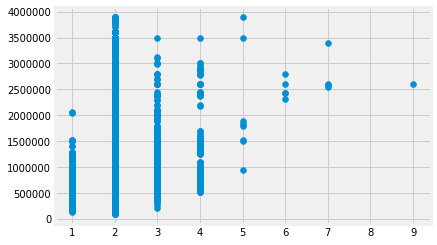

In [32]:
plt.scatter(df_starKL_condo['carpark'], df_starKL_condo['price'])

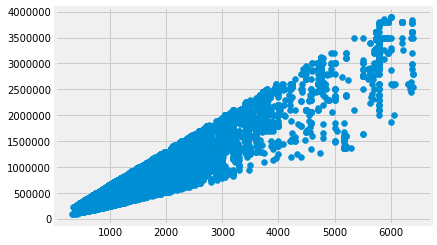

In [106]:
plt.scatter(df_starKL_condo['size'], df_starKL_condo['price'])

In [14]:
#prediction, check its error
predictions = rf.predict(test_X)
errors = abs(predictions - test_Y)
np.mean(errors)

49269.145978316825

In [20]:
#prediction, check its error
predictions = grid_search.predict(test_X)
errors = abs(predictions - test_Y)
np.mean(errors)

60028.130855410156

In [30]:
#prediction, check its error
predictions = rf2.predict(test_X)
errors = abs(predictions - test_Y)
np.mean(errors)

60028.130855410156

In [32]:
df_starKL_condo['estimatedPrice'] = rf.predict(df_features)

# Starts here

# KL Selangor

In [9]:
# Function to get Base year market basket proportion
# Returns a dict of district to proportion mapping
def getBaseYearBasketProportions(df_base):
    baseYear_basketProp_dict = {}
    for state in df_base['State'].unique():
        count_Series = df_base[df_base['State'] == state].groupby('Type')\
                                                                        .count()\
                                                                        .apply(lambda x: (x / x.sum()) * 100)\
                                                                        ['Location_property']
        baseYear_basketProp_dict[state] = {'Condominium' : round(count_Series[0],2), 
                                            'House': round(count_Series[1],2)}
    return baseYear_basketProp_dict

In [10]:
def getSampleSize(BaseYear_Proportion_dict,df_subset):
    sampleSize = {}
    for i in BaseYear_Proportion_dict:
        weights = [BaseYear_Proportion_dict[i][j] for j in BaseYear_Proportion[i]]
        choiceP = choices(df_subset['Type'].unique(),weights,k = df_subset.shape[0])
        sampleSize[i] = Counter(choiceP)
    return sampleSize

In [4]:
def modelPrice(df,category):
    result_dict = {}
    features_list = ['furnishing','num_bedroom','num_bath','carpark',
                'size','region_type','ClosetoLRT','ClosetoKTM',
                'ClosetoMRT','ClosetoMonorail'] 
    #if there is categorical column
    df_categoricalV = pd.get_dummies(df[[i for i in features_list if df[i].dtype == 'object']])

    df_numericalV = df[[i for i in features_list if df[i].dtype != 'object']]

    df_features = pd.concat([df_numericalV,df_categoricalV],join_axes= [df_numericalV.index],axis = 1).copy()
    #df_features.drop('region_type_', axis = 1,inplace = True)

    # Split the data into training and testing sets
    train_X, test_X, train_Y, test_Y = train_test_split(df_features, df['logPrice'], 
                                                test_size = 0.25, random_state = 42)
    # Instantiate model with 100 decision trees
    rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
    
    # Train the model on training data
    rf.fit(train_X, train_Y)
    
    #prediction, get rmse, mape
    train_predictions = rf.predict(train_X)
    train_rmse = sqrt(mean_squared_error(train_Y,train_predictions))
    test_predictions = rf.predict(test_X)
    test_rmse = sqrt(mean_squared_error(test_Y,test_predictions))
    train_absoluteError = abs(train_predictions - train_Y)
    train_mape = 100 - np.mean(100*(train_absoluteError/train_Y))
    test_absoluteError = abs(test_predictions - test_Y)
    test_mape = 100 - np.mean(100*(test_absoluteError/test_Y))
    
    #store result
    result_dict[str(category)] = {}
    result_dict[str(category)]['train_rmse'] = train_rmse
    result_dict[str(category)]['test_rmse'] = test_rmse
    result_dict[str(category)]['train_mape'] = round(train_mape,2)
    result_dict[str(category)]['test_mape'] = round(test_mape,2)
    
    #features importance
    featuresImportance_list = \
    sorted([(i,j) for i,j in zip(df_features.columns,
            rf.feature_importances_)],key = lambda x:x[1],reverse = True)

    return (rf.predict(df_features),featuresImportance_list,result_dict)

In [15]:
#get market proportion from 2013
BaseYear_Proportion = getBaseYearBasketProportions(df_merged_KlSel[df_merged_KlSel['year'] == 2013])
#get sample size from market proportion 2013
BaseYear_SampleSize = getSampleSize(BaseYear_Proportion,df_merged_KlSel[df_merged_KlSel['year'] == 2013])

In [36]:
# get base price first,year = 2010
columns_list = ['furnishing','num_bedroom','num_bath','carpark',
                'size','region_type','ClosetoLRT','ClosetoKTM',
                'ClosetoMRT','ClosetoMonorail'] 
BasePrice_dict = {}
ModelResult_list = []
Factor_list = []
AllModelResultdf_list = []
AllFactordf_list = []
df_merged_KlSel['logPrice'] = np.log(df_merged_KlSel['price'])
for state in df_merged_KlSel['State'].unique():
    for htype in df_merged_KlSel['Type'].unique():
        df_base = df_merged_KlSel[(df_merged_KlSel['State'] == state)
                                   & (df_merged_KlSel['Type'] == htype)
                                 & (df_merged_KlSel['year'] == 2013)].copy()
        df_baseUnique = df_base[columns_list + ['logPrice']].drop_duplicates()
        df_baseUnique['estimatedPrice'],df_baseFeatures,df_baseResult = modelPrice(df_baseUnique,state+'_'+htype)
        BasePrice_dict[(state,htype)] = np.mean(np.exp(df_baseUnique['estimatedPrice'])\
                                             .sample(BaseYear_SampleSize[state][htype], replace = True))
        ModelResult_list.append((state+'_'+htype,df_baseResult))
        Factor_list.append((state+'_'+htype,df_baseFeatures))

#calculate mean price for years other than 2013
MeanPrice_dict = {}
for state in df_merged_KlSel['State'].unique():
    for htype in df_merged_KlSel['Type'].unique():
        for year in [i for i in df_merged_KlSel['year'].unique() if i!=2013]:
            df_subset = df_merged_KlSel[(df_merged_KlSel['State'] == state)
                                       & (df_merged_KlSel['Type'] == htype)
                                     & (df_merged_KlSel['year'] == year)].copy()
            df_subsetUnique = df_subset[columns_list + ['logPrice']].drop_duplicates()
            df_subsetUnique['estimatedPrice'],df_subsetFeatures,df_subsetResult = \
                                                modelPrice(df_subsetUnique,state+'_'+htype+'_'+str(year))
            MeanPrice_dict[(state,htype,year)] = np.mean(np.exp(df_subsetUnique['estimatedPrice'])\
                                                 .sample(BaseYear_SampleSize[state][htype], replace = True))
            ModelResult_list.append((state+'_'+htype+'_'+str(year),df_subsetResult))
            Factor_list.append((state+'_'+htype+'_'+str(year),df_subsetFeatures))
            
#save to excel
df_temp1 = pd.DataFrame([j[i] for i,j in ModelResult_list])
df_temp1['Category'] = [i[0] for i in ModelResult_list]
df_temp1.to_excel('../data/excel/ModelResult.xlsx',index = False)

df_temp2 = pd.DataFrame([j + (i[0],) for i in Factor_list for j in i[1]])
df_temp2.columns = ['Feature','FeatureImportance','Category']
df_temp2.to_excel('../data/excel/FeaturesResult.xlsx',index = False)

In [50]:
#source http://www.stat.si/StatWeb/File/DocSysFile/8346
#calculate reprice index

#get number of listing by state,type and year
numlistings_dict = {(i[0],i[1],i[2]):i[3] for i in 
                df_merged_KlSel.groupby(['State','Type','year'])['Location_property'].count().reset_index().values}

#get ratio of index of raw price
denom_Index = {(i[0],i[1]):BasePrice_dict[i]**(1/(numlistings_dict[i[0],i[1],2013])) for i in BasePrice_dict} 

numerator_Index = {(i[0],i[1],i[2]):MeanPrice_dict[i]**(1/(numlistings_dict[i[0],i[1],i[2]])) 
                   for i in MeanPrice_dict}
ratio_Index = {(i[0],i[1],i[2]):numerator_Index[i]/denom_Index[(i[0],i[1])] for i in numerator_Index}

#get ratio of index of quality-adjusted price
PI_dict = {i:(MeanPrice_dict[i]/BasePrice_dict[(i[0],i[1])])*100 for i in MeanPrice_dict}

#get final index
reprice_PI_dict = {(i[0],i[1],i[2]):(ratio_Index[i]/PI_dict[i])*10000 for i in PI_dict}
pd.Series(reprice_PI_dict).to_excel('../data/excel/repriceIndex_KlSel_ByYear.xlsx')

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

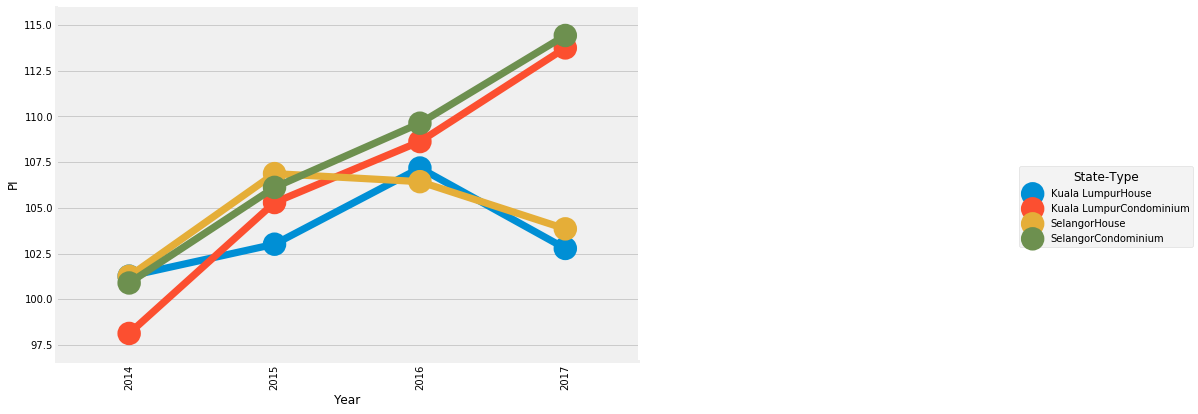

In [80]:
df_PI = pd.DataFrame([(i[0],i[1],i[2],reprice_PI_dict[i]) for i in reprice_PI_dict])
df_PI.columns = ['State','Type','Year','PI']
df_PI['State-Type'] = df_PI['State'] + df_PI['Type']
plt.figure(figsize = (20,10))
g = sns.factorplot(x = 'Year', y = 'PI', hue = 'State-Type', data = df_PI)
g.fig.set_size_inches(20,6)
plt.xticks(rotation = '90')

# All States -Annual

In [7]:
def modelPrice(df,category,features_list):
    result_dict = {}
    #features_list = ['furnishing','num_bedroom','num_bath','carpark',
    #            'size'] 
    #if there is categorical column
    df_categoricalV = pd.get_dummies(df[[i for i in features_list if df[i].dtype == 'object']])

    df_numericalV = df[[i for i in features_list if df[i].dtype != 'object']]

    df_features = pd.concat([df_numericalV,df_categoricalV],join_axes= [df_numericalV.index],axis = 1).copy()
    #df_features.drop('region_type_', axis = 1,inplace = True)

    # Split the data into training and testing sets
    train_X, test_X, train_Y, test_Y = train_test_split(df_features, df['logPrice'], 
                                                test_size = 0.25, random_state = 42)
    # Instantiate model with 100 decision trees
    rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
    
    # Train the model on training data
    rf.fit(train_X, train_Y)
    
    #prediction, get rmse, mape
    train_predictions = rf.predict(train_X)
    train_rmse = sqrt(mean_squared_error(train_Y,train_predictions))
    test_predictions = rf.predict(test_X)
    test_rmse = sqrt(mean_squared_error(test_Y,test_predictions))
    train_absoluteError = abs(train_predictions - train_Y)
    train_mape = 100 - np.mean(100*(train_absoluteError/train_Y))
    test_absoluteError = abs(test_predictions - test_Y)
    test_mape = 100 - np.mean(100*(test_absoluteError/test_Y))
    
    #store result
    result_dict[str(category)] = {}
    result_dict[str(category)]['train_rmse'] = train_rmse
    result_dict[str(category)]['test_rmse'] = test_rmse
    result_dict[str(category)]['train_mape'] = round(train_mape,2)
    result_dict[str(category)]['test_mape'] = round(test_mape,2)
    
    #features importance
    featuresImportance_list = \
    sorted([(i,j) for i,j in zip(df_features.columns,
            rf.feature_importances_)],key = lambda x:x[1],reverse = True)

    return (rf.predict(df_features),featuresImportance_list,result_dict)

In [8]:
#Star

df_star = pd.read_csv('../data/processed/Propwall_Report_ForSale-28-3-18.csv')
# Load Property to District mapping
df_district = pd.read_excel('../data/external/kl_sel_districted.xlsx')
# Join the two set using Location_property as key
df_star = df_star.join(df_district, on='Location_property')
#save unique location_property to naz for getting public transport info for sales
pd.Series(df_star['Location_property'].unique(),name = 'Location_property')\
.to_excel('../data/excel/UniqueLocationProperty_StarSales.xlsx')

#add column of quarter and year-quarter
df_star['quarter'] = ((df_star['month']-1)//3+1)

df_star['year-quarter'] = df_star['year'].astype(str) + '-' + df_star['quarter'].astype(str)
df_star['State'] = df_star['State'].map(lambda x:'Selangor' if x == 'Petaling Jaya' else x)
df_star['State_Category'] = df_star['State'].map(lambda x:'Others' if x not in ['Kuala Lumpur','Selangor']
                                                else x)
#fill carpark, most of carpark is 0
df_star['carpark'] = df_star['carpark'].map(lambda x:2 if x == 0  else x)

df_star['num_bath'] = df_star\
                            .apply(lambda row: row['bath'] if row['bath'] != 0 \
                                   else math.ceil(row['num_bedroom']/2), axis=1)

In [109]:
### get base price first,year = 2010
columns_list = ['furnishing','num_bedroom','num_bath','carpark',
                'size'] 
BasePrice_dict = {}
ModelResult_list = []
Factor_list = []
AllModelResultdf_list = []
AllFactordf_list = []
df_star['logPrice'] = np.log(df_star['price'])
df_base = df_star[(df_star['year'] == 2013)].copy()
df_baseUnique = df_base[columns_list + ['logPrice']].drop_duplicates()
df_baseUnique['estimatedPrice'],df_baseFeatures,df_baseResult = modelPrice(df_baseUnique,'2013',columns_list)
BasePrice_dict['2013'] = np.mean(df_baseUnique['estimatedPrice'])
ModelResult_list.append(('2013',df_baseResult))
Factor_list.append(('2013',df_baseFeatures))

#calculate mean of log price for years other than 2013
MeanPrice_dict = {}
for year in [i for i in df_star['year'].unique() if i!=2013]:
    df_subset = df_star[(df_star['year'] == year)].copy()
    df_subsetUnique = df_subset[columns_list + ['logPrice']].drop_duplicates()
    df_subsetUnique['estimatedPrice'],df_subsetFeatures,df_subsetResult = \
                                        modelPrice(df_subsetUnique,str(year),columns_list)
    MeanPrice_dict[str(year)] = np.mean(df_subsetUnique['estimatedPrice'])
    ModelResult_list.append((str(year),df_subsetResult))
    Factor_list.append((str(year),df_subsetFeatures))

#save to excel
df_temp1 = pd.DataFrame([j[i] for i,j in ModelResult_list])
df_temp1['Category'] = [i[0] for i in ModelResult_list]
df_temp1.to_excel('../data/excel/ModelResult_AllStates.xlsx',index = False)

df_temp2 = pd.DataFrame([j + (i[0],) for i in Factor_list for j in i[1]])
df_temp2.columns = ['Feature','FeatureImportance','Category']
df_temp2.to_excel('../data/excel/FeaturesResult_AllStates.xlsx',index = False)

In [116]:
#calculate reprice index

#get number of listing by state,type and year
numlistings_dict = {str(i[0]):i[1] for i in 
                df_star.groupby(['year'])['Location_property'].count().reset_index().values}


#log price per listing
#logPrice_dict = {i:SumPrice_dict[i]/numlistings_dict[i] for i in numlistings_dict}

#get real price average
realPrice_dict = {str(i):j for i,j in dict(df_star.groupby('year')['price'].mean()).items()}

#get ratio of index of raw price
denom_Index = {i:realPrice_dict[i]**(1/(numlistings_dict[i])) for i in BasePrice_dict} 

numerator_Index = {i:realPrice_dict[i]**(1/(numlistings_dict[i]))
                   for i in MeanPrice_dict}
ratio_Index = {i:numerator_Index[i]/denom_Index['2013'] for i in numerator_Index}
ratio_Index_values = [j for i,j in sorted(ratio_Index.items())]

MeanPrice_dict.update(BasePrice_dict)
#get ratio of index of quality-adjusted price
PI_dict = {i:np.exp(MeanPrice_dict[i])
           /np.exp(MeanPrice_dict['2013']) for i in MeanPrice_dict}
PI_listings_dict = {i:PI_dict[i]*(1/numlistings_dict[i]) for i in PI_dict}
PI_listings_values = [j for i,j in sorted(PI_listings_dict.items())]
num_dict = {j:i for i,j in zip(range(len(PI_dict)),sorted(PI_dict.keys()))}

#get final index
reprice_PI_dict = {i:ratio_Index[i]/
                   PI_dict[i] for i in PI_dict}
#reprice_PI_dict = {i:(ratio_Index[i]/PI_dict[i])*10000 for i in PI_dict}
#pd.Series(reprice_PI_dict).to_excel('../data/excel/repriceIndex_ByYear.xlsx')

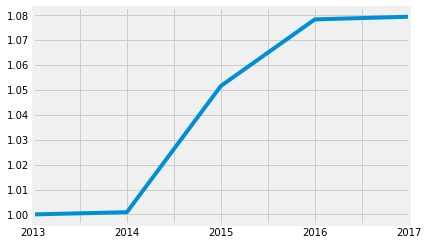

In [117]:
pd.Series(reprice_PI_dict).plot(kind = 'line')

# All States - Quarter

In [22]:
def modelPrice(df,category,features_list):
    result_dict = {}
    #features_list = ['furnishing','num_bedroom','num_bath','carpark',
    #            'size'] 
    #if there is categorical column
    df_categoricalV = pd.get_dummies(df[[i for i in features_list if df[i].dtype == 'object']])

    df_numericalV = df[[i for i in features_list if df[i].dtype != 'object']]

    df_features = pd.concat([df_numericalV,df_categoricalV],join_axes= [df_numericalV.index],axis = 1).copy()
    #df_features.drop('region_type_', axis = 1,inplace = True)

    # Split the data into training and testing sets
    train_X, test_X, train_Y, test_Y = train_test_split(df_features, df['logPrice'], 
                                                test_size = 0.25, random_state = 42)
    # Instantiate model with 100 decision trees
    rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
    
    # Train the model on training data
    rf.fit(train_X, train_Y)
    
    #prediction, get rmse, mape
    train_predictions = rf.predict(train_X)
    train_rmse = sqrt(mean_squared_error(train_Y,train_predictions))
    test_predictions = rf.predict(test_X)
    test_rmse = sqrt(mean_squared_error(test_Y,test_predictions))
    train_absoluteError = abs(train_predictions - train_Y)
    train_mape = 100 - np.mean(100*(train_absoluteError/train_Y))
    test_absoluteError = abs(test_predictions - test_Y)
    test_mape = 100 - np.mean(100*(test_absoluteError/test_Y))
    
    #store result
    result_dict[str(category)] = {}
    result_dict[str(category)]['train_rmse'] = train_rmse
    result_dict[str(category)]['test_rmse'] = test_rmse
    result_dict[str(category)]['train_mape'] = round(train_mape,2)
    result_dict[str(category)]['test_mape'] = round(test_mape,2)
    
    #features importance
    featuresImportance_list = \
    sorted([(i,j) for i,j in zip(df_features.columns,
            rf.feature_importances_)],key = lambda x:x[1],reverse = True)

    return (rf.predict(df_features),featuresImportance_list,result_dict)

In [20]:
def getRepricingIndex(df,base_year = 2013):
    print('your base year: ' + str(base_year))
    BasePrice_dict = {}
    ModelResult_list = []
    Factor_list = []
    AllModelResultdf_list = []
    AllFactordf_list = []
    columns_list = ['furnishing','num_bedroom','num_bath','carpark',
                        'Type','ClosetoLRT','ClosetoKTM','ClosetoMRT','ClosetoMonorail']  
    if base_year==2013:
        ### calculate mean of real log price and estimate log price for base year
        df['logPrice'] = np.log(df['Price_persqft'])
        df_base = df[(df['year'] == int(base_year))].copy()
        df_baseUnique = df_base[columns_list + ['logPrice']].drop_duplicates()
        df_baseUnique['estimatedPrice'],df_baseFeatures,df_baseResult = modelPrice(df_baseUnique,'2013',columns_list)
        BasePrice_dict[str(base_year)] = np.mean(df_baseUnique['estimatedPrice'])
        ModelResult_list.append((str(base_year),df_baseResult))
        Factor_list.append((str(base_year),df_baseFeatures))
    
    #calculate mean price for years other than 2013
    MeanPrice_dict = {}
    df['logPrice'] = np.log(df['Price_persqft'])
    for yearQ in df['year-quarter'].unique():
        df_subset = df[(df['year-quarter'] == yearQ)].copy()
        df_subsetUnique = df_subset[columns_list + ['logPrice']].drop_duplicates()
        df_subsetUnique['estimatedPrice'],df_subsetFeatures,df_subsetResult = \
                                            modelPrice(df_subsetUnique,str(yearQ),columns_list)
        MeanPrice_dict[str(yearQ)] = np.mean(df_subsetUnique['estimatedPrice'])
        ModelResult_list.append((str(yearQ),df_subsetResult))
        Factor_list.append((str(yearQ),df_subsetFeatures))

    #store model performance result and    
    #save to excel
    df_temp1 = pd.DataFrame([j[i] for i,j in ModelResult_list])
    df_temp1['Category'] = [i[0] for i in ModelResult_list]
    df_temp1.to_excel('../data/excel/ModelResult_Quarter_PricePerSqft.xlsx',index = False)

    #store feature importance result and
    #save to excel
    df_temp2 = pd.DataFrame([j + (i[0],) for i in Factor_list for j in i[1]])
    df_temp2.columns = ['Feature','FeatureImportance','Category']
    df_temp2.to_excel('../data/excel/FeaturesResult_Quarter_PricePerSqft.xlsx',index = False)

    ### calculate reprice index
    #get number of listing by state,type and year-quarter
    numlistings_dict = {str(i[0]):i[1] for i in 
                    df.groupby(['year-quarter'])['Location_property'].count().reset_index().values}

    #get real price average
    realPrice_dict = {str(i):j for i,j in dict(df.groupby('year-quarter')['Price_persqft'].mean()).items()}
    
    if base_year == 2013:
        realPrice_baseyear = df[df['year'] == base_year]['Price_persqft'].mean()
    else:
        realPrice_baseyear = df[df['year-quarter'] == '2013-1']['Price_persqft'].mean()

    #get ratio of index of raw price
    if base_year == 2013:
        denom_Index = {'2013':MeanPrice_dict['2013']**(1/(numlistings_dict['2013']))}
    else:
        denom_Index = {'2013-1':MeanPrice_dict['2013-1']**(1/(numlistings_dict['2013-1']))} 
    
    numerator_Index = {i:realPrice_dict[i]**(1/(numlistings_dict[i]))
                       for i in MeanPrice_dict}

    ratio_Index = {i:numerator_Index[i]/denom_Index['2013-1'] for i in numerator_Index}

    #get ratio of index of quality-adjusted price
    if base_year == 2013:
        PI_dict = {i:np.exp(MeanPrice_dict[i])
                   /np.exp(BasePrice_dict['2013']) for i in MeanPrice_dict}        
    else:    
        PI_dict = {i:np.exp(MeanPrice_dict[i])
                   /np.exp(MeanPrice_dict['2013-1']) for i in MeanPrice_dict}

    #get final index
    reprice_PI_dict = {i:(ratio_Index[i]/PI_dict[i])*100 for i in PI_dict}
    pd.Series(reprice_PI_dict).to_excel('../data/excel/repriceIndex_ByYearQuarter_PricePerSqft.xlsx')
        
    return (PI_dict,reprice_PI_dict)

In [12]:
PI_result, repricePI_result = getRepricingIndex(df_star,'2013-1')

your base year: 2013-1


In [23]:
#price per sqft
PI_result, repricePI_result = getRepricingIndex(df_star,'2013-1')

your base year: 2013-1


In [1]:
import numpy as np
sample_size = 100
n = 10
X = np.random.uniform( low=0, high=1, size=(sample_size, n) )
Y = np.random.uniform( low=0, high=1, size=(sample_size, n) )

In [12]:
import math
ans = np.array([])
for i,j in enumerate(X):
    ans = np.append(ans,[np.sqrt(np.sum([(a-b)**2 for a,b in zip(j,Y[i])]))])

In [28]:
A = np.array([[1,2,3]])
B = np.array([[2,3,4]])
for i,j in enumerate(A):
    print(np.sqrt(np.sum([(a-b)**2 for a,b in zip(j,B[i])])))

1.73205080757


In [47]:
from sklearn.metrics.pairwise import euclidean_distances
A = [1,2,3]
B = [2,3,4]
ans2 = np.array([])
for i,j in enumerate(X):
    print(i,j)
    ans2 = np.append(ans2,euclidean_distances([j],[Y[i]]))
ans2

0 [ 0.9059698   0.38254998  0.24503157  0.29695009  0.14855492  0.69725931
  0.65556153  0.1409688   0.44551923  0.94449195]
1 [ 0.22800919  0.47283209  0.04580833  0.66100626  0.96241048  0.28876523
  0.23004007  0.71322152  0.28060792  0.46418307]
2 [ 0.81995432  0.26677298  0.58893083  0.56502136  0.90719227  0.77778651
  0.19059919  0.47074136  0.48326217  0.38923249]
3 [ 0.15144157  0.35928606  0.53331737  0.30799027  0.77776051  0.57797207
  0.45902783  0.67158163  0.11037824  0.28365139]
4 [ 0.48155667  0.27853068  0.26899941  0.62043459  0.24988967  0.11111079
  0.55582517  0.84877715  0.80343866  0.03758711]
5 [ 0.98693036  0.02621496  0.46827307  0.88709398  0.52106245  0.33304166
  0.0662522   0.52615347  0.41399651  0.76215128]
6 [ 0.83809418  0.10542348  0.51168355  0.91468023  0.92055492  0.60742944
  0.03815485  0.62368475  0.12789664  0.49626747]
7 [ 0.45085648  0.07390481  0.88900609  0.008136    0.10934941  0.7515075
  0.37627278  0.81746011  0.35713404  0.26615517]
8

array([ 1.34964049,  1.62492144,  1.42018215,  0.99034791,  1.35724439,
        1.05172755,  1.43307188,  1.16150971,  1.13469002,  1.37300045,
        1.82925291,  1.02953912,  1.08972494,  1.28291897,  1.74857893,
        1.33258181,  1.23864333,  0.97993621,  1.16009809,  0.84813182,
        1.66947924,  1.53322642,  0.85117514,  1.42200832,  1.41229888,
        1.42699809,  1.29704605,  1.08670211,  1.01112371,  1.39747265,
        1.56569665,  1.42409423,  1.24935688,  1.4275532 ,  1.41503461,
        0.83723902,  1.2244306 ,  1.6395955 ,  1.12791662,  1.06670132,
        1.62351245,  1.21617829,  1.61614181,  0.91796757,  1.50268059,
        1.26624945,  1.35931831,  1.10829858,  1.36630192,  1.42615131,
        1.27783072,  1.04928924,  1.08193227,  1.45596424,  1.29324767,
        1.52395205,  0.62922266,  1.02630387,  0.93191593,  1.2336506 ,
        1.59114367,  1.4329518 ,  1.46919779,  1.44688476,  1.67367141,
        0.9184158 ,  0.6902534 ,  1.1048058 ,  1.23816656,  1.55

In [34]:
from scipy.spatial import distance
a = [ 0.88857353,0.01574022]
b = [  0.42493475,0.84982042]
dst = distance.euclidean(a,b)

# Experiment

In [17]:
def modelPrice(dfModel,dfRaw,category,features_list):
    result_dict = {}
    #features_list = ['furnishing','num_bedroom','num_bath','carpark',
    #            'size'] 
    #if there is categorical column
    df_categoricalV = pd.get_dummies(dfModel[[i for i in features_list if dfModel[i].dtype == 'object']])

    df_numericalV = dfModel[[i for i in features_list if dfModel[i].dtype != 'object']]

    df_features = pd.concat([df_numericalV,df_categoricalV],join_axes= [df_numericalV.index],axis = 1).copy()
    #df_features.drop('region_type_', axis = 1,inplace = True)
    
    df_categoricalV_Raw = pd.get_dummies(dfRaw[[i for i in features_list if dfRaw[i].dtype == 'object']])

    df_numericalV_Raw = dfRaw[[i for i in features_list if dfRaw[i].dtype != 'object']]
    
    dfRaw_features = pd.concat([df_numericalV_Raw,df_categoricalV_Raw],
                               join_axes= [df_numericalV_Raw.index],axis = 1).copy()
    
    # Split the data into training and testing sets
    train_X, test_X, train_Y, test_Y = train_test_split(df_features, dfModel['logPrice'], 
                                                test_size = 0.25, random_state = 42)
    # Instantiate model with 100 decision trees
    rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
    
    # Train the model on training data
    rf.fit(train_X, train_Y)
    
    #prediction, get rmse, mape
    train_predictions = rf.predict(train_X)
    train_rmse = sqrt(mean_squared_error(train_Y,train_predictions))
    test_predictions = rf.predict(test_X)
    test_rmse = sqrt(mean_squared_error(test_Y,test_predictions))
    train_absoluteError = abs(train_predictions - train_Y)
    train_mape = 100 - np.mean(100*(train_absoluteError/train_Y))
    test_absoluteError = abs(test_predictions - test_Y)
    test_mape = 100 - np.mean(100*(test_absoluteError/test_Y))
    
    #store result
    result_dict[str(category)] = {}
    result_dict[str(category)]['train_rmse'] = train_rmse
    result_dict[str(category)]['test_rmse'] = test_rmse
    result_dict[str(category)]['train_mape'] = round(train_mape,2)
    result_dict[str(category)]['test_mape'] = round(test_mape,2)
    
    #features importance
    featuresImportance_list = \
    sorted([(i,j) for i,j in zip(df_features.columns,
            rf.feature_importances_)],key = lambda x:x[1],reverse = True)

    return (rf.predict(dfRaw_features),featuresImportance_list,result_dict)

In [19]:
### get base price first,year = 2010
columns_list = ['furnishing','num_bedroom','num_bath','carpark',
                
BasePrice_dict = {}
ModelResult_list = []
Factor_list = []
AllModelResultdf_list = []
AllFactordf_list = []
df_star['logPrice'] = np.log(df_star['Price_persqft'])
df_base = df_star[(df_star['year'] == 2013)].copy()
df_baseUnique = df_base[columns_list + ['logPrice']].drop_duplicates()
df_base['estimatedPrice'],df_baseFeatures,df_baseResult = modelPrice(df_baseUnique,
                                                                           df_base,'2013',columns_list)
BasePrice_dict['2013'] = np.mean(df_base['estimatedPrice'])
ModelResult_list.append(('2013',df_baseResult))
Factor_list.append(('2013',df_baseFeatures))

#calculate mean price for years other than 2013
MeanPrice_dict = {}
df_starUnique = df_star[columns_list + ['logPrice']].drop_duplicates()
df_star['estimatedPrice'],df_Features,df_Result = modelPrice(df_starUnique,df_star,'All',columns_list)
ModelResult_list.append((str('All'),df_Result))
Factor_list.append((str('All'),df_Features))
for yearQ in df_star['year-quarter'].unique():
    MeanPrice_dict[str(yearQ)] = np.mean(df_star[df_star['year-quarter'] == yearQ]['estimatedPrice'])

'''
#calculate mean price for years other than 2013
MeanPrice_dict = {}
for yearQ in [i for i in df_star['year-quarter'].unique() if i!=2013]:
    df_subset = df_star[(df_star['year-quarter'] == yearQ)].copy()
    df_subsetUnique = df_subset[columns_list + ['logPrice']].drop_duplicates()
    df_subsetUnique['estimatedPrice'],df_subsetFeatures,df_subsetResult = \
                                        modelPrice(df_subsetUnique,str(yearQ),columns_list)
    MeanPrice_dict[str(yearQ)] = np.mean(df_subsetUnique['estimatedPrice'])
    ModelResult_list.append((str(yearQ),df_subsetResult))
    Factor_list.append((str(yearQ),df_subsetFeatures))
'''
    
#save to excel
df_temp1 = pd.DataFrame([j[i] for i,j in ModelResult_list])
df_temp1['Category'] = [i[0] for i in ModelResult_list]
df_temp1.to_excel('../data/excel/ModelResult_All_Pricepersqft.xlsx',index = False)

df_temp2 = pd.DataFrame([j + (i[0],) for i in Factor_list for j in i[1]])
df_temp2.columns = ['Feature','FeatureImportance','Category']
df_temp2.to_excel('../data/excel/FeaturesResult_All_Pricepersqft.xlsx',index = False)

In [10]:
df_temp2

Feature  FeatureImportance Category
0                         size              0.945     2013
1                  num_bedroom              0.013     2013
2   furnishing_Fully Furnished              0.005     2013
3             ClosetoLRT_False              0.004     2013
4              ClosetoLRT_True              0.004     2013
5       furnishing_Unfurnished              0.004     2013
6                     num_bath              0.004     2013
7             ClosetoKTM_False              0.004     2013
8             ClosetoMRT_False              0.003     2013
9    furnishing_Semi-Furnished              0.003     2013
10             ClosetoMRT_True              0.003     2013
11             ClosetoKTM_True              0.003     2013
12       ClosetoMonorail_False              0.003     2013
13        ClosetoMonorail_True              0.002     2013
14                     carpark              0.000     2013
15                        size              0.945      All
16                 num_bedroom              0.013      All
17                    num_bath              0.007      All
18  furnishing_Fully Furnished              0.004      All
19      furnishing_Unfurnished              0.003      All
20                     carpark              0.003      All
21            ClosetoLRT_False              0.003      All
22             ClosetoLRT_True              0.003      All
23            ClosetoKTM_False              0.003      All
24   furnishing_Semi-Furnished              0.003      All
25            ClosetoMRT_False              0.003      All
26             ClosetoMRT_True              0.003      All
27       ClosetoMonorail_False              0.002      All
28             ClosetoKTM_True              0.002      All
29        ClosetoMonorail_True              0.002      All

In [66]:
### calculate reprice index

#get number of listing by state,type and year
numlistings_dict = {str(i[0]):i[1] for i in 
                df_star.groupby(['year-quarter'])['Location_property'].count().reset_index().values}

#get real price average
realPrice_dict = {str(i):j for i,j in dict(df_star.groupby('year-quarter')['price'].mean()).items()}
realPrice_baseyear = df_star[df_star['year'] == 2013]['price'].mean()

#get ratio of index of raw price
denom_Index = {'2013-1':MeanPrice_dict['2013-1']
               **(1/(numlistings_dict['2013-1']))} 

numerator_Index = {i:realPrice_dict[i]**(1/(numlistings_dict[i]))
                   for i in MeanPrice_dict}

ratio_Index = {i:numerator_Index[i]/denom_Index['2013-1'] for i in numerator_Index}

#get ratio of index of quality-adjusted price
PI_dict = {i:np.exp(MeanPrice_dict[i])
           /np.exp(MeanPrice_dict['2013-1']) for i in MeanPrice_dict}

#get final index
reprice_PI_dict = {i:(ratio_Index[i]/PI_dict[i])*100 for i in PI_dict}
pd.Series(reprice_PI_dict).to_excel('../data/excel/repriceIndex_ByYearQuarter_All.xlsx')

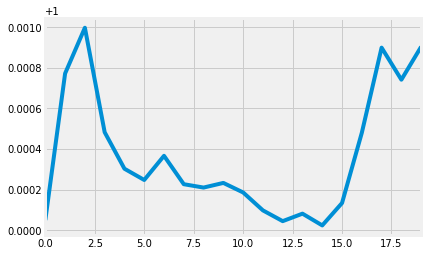

In [71]:
pd.Series([i for i in ratio_Index.values()]).plot()

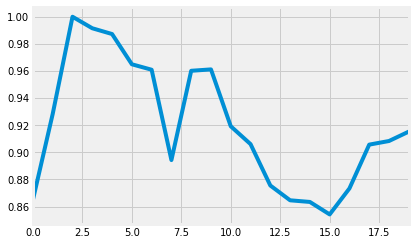

In [70]:
pd.Series([i for i in PI_dict.values()]).plot()

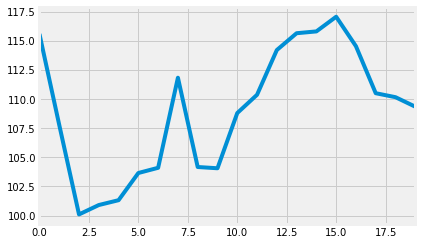

In [69]:
pd.Series([i for i in reprice_PI_dict.values()]).plot()

In [41]:
### calculate reprice index

#get number of listing by state,type and year
numlistings_dict = {str(i[0]):i[1] for i in 
                df_star.groupby(['year-quarter'])['Location_property'].count().reset_index().values}

#get real price average
realPrice_dict = {str(i):j for i,j in dict(df_star.groupby('year-quarter')['price'].mean()).items()}
realPrice_baseyear = df_star[df_star['year'] == 2013]['price'].mean()

#get ratio of index of raw price
denom_Index = {'2013-1':MeanPrice_dict['2013-1']
               **(1/(numlistings_dict['2013-1']))} 

numerator_Index = {i:realPrice_dict[i]**(1/(numlistings_dict[i]))
                   for i in MeanPrice_dict}

ratio_Index = {i:numerator_Index[i]/denom_Index['2013-1'] for i in numerator_Index}

#get ratio of index of quality-adjusted price
PI_dict = {i:np.exp(MeanPrice_dict[i])
           /np.exp(MeanPrice_dict['2013-1']) for i in MeanPrice_dict}

#get final index
reprice_PI_dict = {i:(ratio_Index[i]/PI_dict[i])*100 for i in PI_dict}
pd.Series(reprice_PI_dict).to_excel('../data/excel/repriceIndex_ByYearQuarter.xlsx')

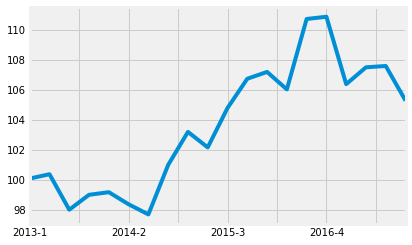

In [142]:
pd.Series(reprice_PI_dict).plot()

In [38]:
df_temp = pd.DataFrame(pd.Series(reprice_PI_dict)).reset_index()
df_temp.columns = ['year-quarter','RepricingIndex']
df_temp2 = df_temp.iloc[4:,:].copy()
df_temp2['Previous_RepricingIndex'] = df_temp.iloc[:16,1].values
df_temp2['Annual Growth'] = ((df_temp2['RepricingIndex'] - df_temp2['Previous_RepricingIndex'])\
                            /df_temp2['Previous_RepricingIndex'])*100

df_temp.to_excel('../data/excel/RepricingIndex_Star.xlsx')
df_temp2.to_excel('../data/excel/RepricingIndex_Growth_Star.xlsx')

year-quarter  RepricingIndex  Previous_RepricingIndex  Annual Growth
4        2014-1         103.173                  102.473          0.683
5        2014-2         102.595                  103.324         -0.705
6        2014-3         102.265                  101.422          0.830
7        2014-4         105.194                  102.569          2.559
8        2015-1         107.631                  103.173          4.320
9        2015-2         106.650                  102.595          3.952
10       2015-3         109.888                  102.265          7.455
11       2015-4         111.928                  105.194          6.402
12       2016-1         112.413                  107.631          4.443
13       2016-2         111.367                  106.650          4.423
14       2016-3         116.690                  109.888          6.190
15       2016-4         117.019                  111.928          4.548
16       2017-1         110.764                  112.413         -1.467
17       2017-2         112.536                  111.367          1.049
18       2017-3         111.620                  116.690         -4.345
19       2017-4         109.256                  117.019         -6.634

In [35]:
#NAPIC
df_napic = pd.DataFrame({'year-quarter':pd.Series([i for i in df_temp['year-quarter']])
                        ,'HPI':pd.Series(np.multiply(np.divide([287181,297885,309849,312940,
                                                               316415,327900,337307,340089,
                                                               345541,351149,360338,361934,
                                                               370667,376247,385201,387258,
                                                               395526,401905,410050,409899],301964),100))})

df_napic2 = df_napic[['year-quarter','HPI']].iloc[4:,:].copy()
df_napic2['Previous_HPI'] = df_napic.iloc[:16,0].values
df_napic2['Annual Growth'] = ((df_napic2['HPI'] - df_napic2['Previous_HPI'])\
                            /df_napic2['Previous_HPI'])*100
df_napic.to_excel('../data/excel/HPI_NAPIC.xlsx')
df_napic2.to_excel('../data/excel/HPI_Growth_NAPIC.xlsx')

# experimentation

In [94]:
#calculate median price for years other than 2013
MedianPrice_dict = {}
for state in df_merged_KlSel['State'].unique():
    for htype in df_merged_KlSel['Type'].unique():
        for year in [i for i in df_merged_KlSel['year'].unique() if i!=2013]:
            df_subset = df_merged_KlSel[(df_merged_KlSel['State'] == state)
                                       & (df_merged_KlSel['Type'] == htype)
                                     & (df_merged_KlSel['year'] == year)].copy()
            df_subset['estimatedPrice'] = modelPrice(df_subset,state+'_'+htype+'_'+str(year))
            MedianPrice_dict[(state,htype,year)] = np.median(df_subset['estimatedPrice']\
                                                 .sample(BaseYear_SampleSize[state][htype], replace = True))

Kuala Lumpur_House_2015 has error: 131104.2783641149
Kuala Lumpur_House_2017 has error: 156939.40647012775
Kuala Lumpur_House_2014 has error: 163407.01888388797
Kuala Lumpur_House_2016 has error: 123201.99381524192
Kuala Lumpur_Condominium_2015 has error: 42455.1198788867
Kuala Lumpur_Condominium_2017 has error: 60101.821029235885
Kuala Lumpur_Condominium_2014 has error: 54009.462289986615
Kuala Lumpur_Condominium_2016 has error: 40943.58252336969
Selangor_House_2015 has error: 124614.79137366837
Selangor_House_2017 has error: 171403.32736171412
Selangor_House_2014 has error: 143664.92778491604
Selangor_House_2016 has error: 121207.11452009367
Selangor_Condominium_2015 has error: 45240.90860024673
Selangor_Condominium_2017 has error: 55337.577067114005
Selangor_Condominium_2014 has error: 50606.76099788711
Selangor_Condominium_2016 has error: 40621.173934960956


In [15]:
df_starKL_condo = df_merged_KlSel[df_merged_KlSel['State'] == 'Kuala Lumpur'].copy()

columns_list = ['furnishing','num_bedroom','num_bath','carpark',
                'size','region_type','ClosetoLRT','ClosetoKTM',
                'ClosetoMRT','ClosetoMonorail','price'] 
df_starKL_condoUnique = df_starKL_condo[columns_list].drop_duplicates()
df_starKL_condoUnique['estimatedprice'],df_starKL_condoModel,df_starKL_condoResult = \
modelPrice(df_starKL_condoUnique,'KLcondo')

In [95]:
MedianPrice_dict

{('Kuala Lumpur', 'Condominium', 2014): 528775.50244886079,
 ('Kuala Lumpur', 'Condominium', 2015): 493781.98247563792,
 ('Kuala Lumpur', 'Condominium', 2016): 473332.16269841266,
 ('Kuala Lumpur', 'Condominium', 2017): 461528.02399999998,
 ('Kuala Lumpur', 'House', 2014): 807692.83999999997,
 ('Kuala Lumpur', 'House', 2015): 833973.06542857143,
 ('Kuala Lumpur', 'House', 2016): 778131.48809523811,
 ('Kuala Lumpur', 'House', 2017): 806371.0,
 ('Selangor', 'Condominium', 2014): 492709.45489643037,
 ('Selangor', 'Condominium', 2015): 477829.90520916966,
 ('Selangor', 'Condominium', 2016): 458302.07142857148,
 ('Selangor', 'Condominium', 2017): 435518.66666666663,
 ('Selangor', 'House', 2014): 826935.36904761905,
 ('Selangor', 'House', 2015): 796909.24484040798,
 ('Selangor', 'House', 2016): 793475.84982827632,
 ('Selangor', 'House', 2017): 818390.14826268493}

In [7]:
{i:(MedianPrice_dict[i]/BasePrice_dict[(i[0],i[1])])*100 for i in MedianPrice_dict}

{('Kuala Lumpur', 'Condominium', 2014): 104.12258235391793,
 ('Kuala Lumpur', 'Condominium', 2015): 97.231915807546,
 ('Kuala Lumpur', 'Condominium', 2016): 93.20508772262949,
 ('Kuala Lumpur', 'Condominium', 2017): 90.8807035595008,
 ('Kuala Lumpur', 'House', 2014): 93.11009614276162,
 ('Kuala Lumpur', 'House', 2015): 96.1396566329942,
 ('Kuala Lumpur', 'House', 2016): 89.70229037595257,
 ('Kuala Lumpur', 'House', 2017): 92.95771562953912,
 ('Selangor', 'Condominium', 2014): 102.1539582743295,
 ('Selangor', 'Condominium', 2015): 99.06896592683587,
 ('Selangor', 'Condominium', 2016): 95.02024005525584,
 ('Selangor', 'Condominium', 2017): 90.29653330218771,
 ('Selangor', 'House', 2014): 102.18328481133132,
 ('Selangor', 'House', 2015): 98.4729972647006,
 ('Selangor', 'House', 2016): 98.0487372880128,
 ('Selangor', 'House', 2017): 101.12736343957009}